In [ ]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
from torchvision.datasets import Caltech101
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [ ]:
from torchvision.transforms import Lambda
from torch.utils.data import Subset, random_split

root = './data'

caltech101 = Caltech101(root, download=True)

# Define the custom transform to convert grayscale images to RGB
def grayscale_to_rgb(image):
    if image.mode == 'L':  
        image = image.convert('RGB') 
    return image

train_transform = transforms.Compose([
    Lambda(grayscale_to_rgb),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224, padding=4),
    transforms.RandomRotation(degrees=(-10, 10)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

validation_transform = transforms.Compose([
      Lambda(grayscale_to_rgb),
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
      Lambda(grayscale_to_rgb),
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# caltech101 = Caltech101(root, transform = test_transform, download=True)

# Split the dataset into train and test sets
train_size = int(0.8 * len(caltech101))
validation_size = int(0.15 * len(caltech101))
test_size = test_size = len(caltech101) - train_size - validation_size

train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(caltech101, [train_size,validation_size, test_size])
#train_dataset, test_dataset = torch.utils.data.random_split(caltech101, [train_size, test_size])
# apply transformation to the data
class TransformedSubset(Subset):
    def __init__(self, dataset, indices, transform=None):
        super(TransformedSubset, self).__init__(dataset, indices)
        self.transform = transform

    def __getitem__(self, idx):
        x, y = self.dataset[self.indices[idx]]
        if self.transform:
            x = self.transform(x)
        return x, y


# apply transformation to the data
train_dataset = TransformedSubset(train_dataset.dataset, train_dataset.indices, transform=train_transform)
validation_dataset = TransformedSubset(validation_dataset.dataset, validation_dataset.indices, transform=validation_transform)
test_dataset = TransformedSubset(test_dataset.dataset, test_dataset.indices, transform=test_transform)


# Define the data loaders for the train and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)



131740031it [00:01, 78407034.72it/s]


Extracting ./data/caltech101/101_ObjectCategories.tar.gz to ./data/caltech101


14028800it [00:00, 49682147.98it/s]


Extracting ./data/caltech101/Annotations.tar to ./data/caltech101


In [ ]:


def test(model, test_loader, device):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')

    print("accuracy:", accuracy, "f1:", f1, "precision", precision, "recall", recall)


In [ ]:
# AlexNet code learned from: https://blog.paperspace.com/alexnet-pytorch/
# Define AlexNet architecture
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Instantiate the AlexNet model
net = AlexNet(num_classes=101)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay = 0.001)

def train(net, dataloader, criterion, optimizer, device):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss / (i + 1)


def validate(net, dataloader, criterion, device):
    net.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / (i + 1), correct / total

# Train the model
# num_epochs = 100
# for epoch in range(num_epochs):
#     running_loss = 0.0
#     for i, data in enumerate(train_loader, 0):
#         inputs, labels = data
#         inputs, labels = inputs.to(device), labels.to(device)

#         optimizer.zero_grad()

#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
#     #test(net,validation_loader, device)
#     print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / (i + 1)}")

# print("Finished Training")

num_epochs = 100
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss = train(net, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(net, validation_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

print("Finished Training")

Epoch 1/100, Train Loss: 4.4442, Validation Loss: 4.2356, Validation Accuracy: 0.0861
Epoch 2/100, Train Loss: 4.1911, Validation Loss: 4.1681, Validation Accuracy: 0.0876
Epoch 3/100, Train Loss: 4.0732, Validation Loss: 3.9499, Validation Accuracy: 0.1937
Epoch 4/100, Train Loss: 3.8363, Validation Loss: 3.6967, Validation Accuracy: 0.2460
Epoch 5/100, Train Loss: 3.5924, Validation Loss: 3.4655, Validation Accuracy: 0.2690
Epoch 6/100, Train Loss: 3.3771, Validation Loss: 3.2280, Validation Accuracy: 0.3128
Epoch 7/100, Train Loss: 3.2137, Validation Loss: 3.0583, Validation Accuracy: 0.3543
Epoch 8/100, Train Loss: 2.9734, Validation Loss: 2.8047, Validation Accuracy: 0.3928
Epoch 9/100, Train Loss: 2.7584, Validation Loss: 2.6419, Validation Accuracy: 0.4143
Epoch 10/100, Train Loss: 2.5816, Validation Loss: 2.4537, Validation Accuracy: 0.4543
Epoch 11/100, Train Loss: 2.3933, Validation Loss: 2.3237, Validation Accuracy: 0.4689
Epoch 12/100, Train Loss: 2.2864, Validation Loss: 2

In [ ]:
# Test the model
# net.eval()
# correct = 0
# total = 0
# with torch.no_grad():
#     for data in test_loader:
#         images, labels = data
#         images, labels = images.to(device), labels.to(device)
#         outputs = net(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f"Accuracy of the network on the test images: {100 * correct / total}%")

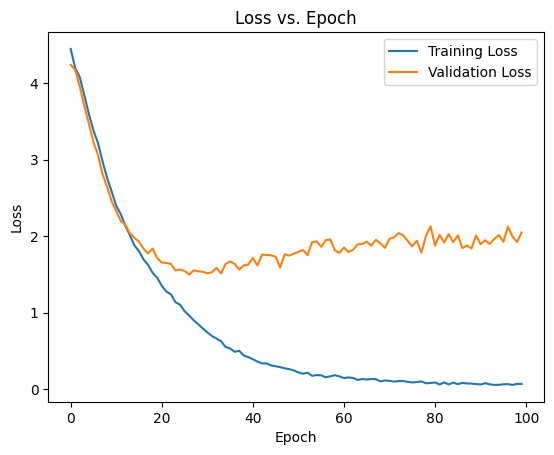

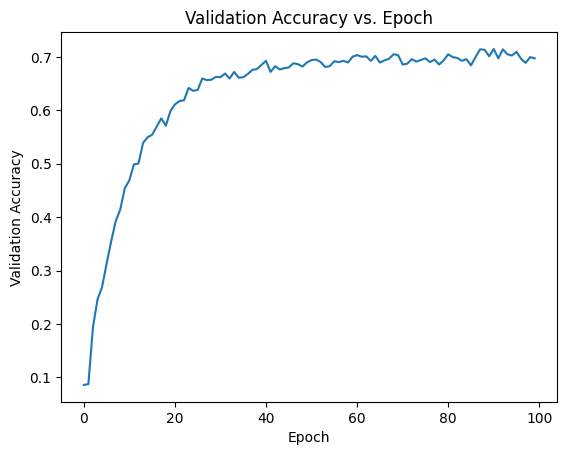

In [8]:
import matplotlib.pyplot as plt

# Plot the training and validation losses
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epoch')

# Plot the validation accuracy
plt.figure()
plt.plot(val_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Epoch')

plt.show()


In [9]:
true_labels = []
predicted_labels = []

net.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='weighted')
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy * 100}%")
print(f"F1 score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


Accuracy: 69.6551724137931%
F1 score: 0.6798869876130368
Precision: 0.7229849861072439
Recall: 0.696551724137931


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
